# Power Laws: Cold Start Energy Forecasting
> The objective of this competition is to forecast **energy consumption** from varying amounts of "cold start" data, and little other building information. That means that for each building in the test set you are given a small amount of data and then asked to predict into the future. Since this format of test data is a bit unusual, we'll give an overview here, with more detail below. Here is a visual representation of the data setup for this problem:

## Features description:

- series_id - An ID number for the time series, matches across datasets
- timestamp - The time of the measurement
- consumption - Consumption (watt-hours) since the last measurement
- temperature - Outdoor temperature (Celsius) during measurement from nearby weather stations, some values missing

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns    
import re
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("consumption_train.csv", parse_dates=["timestamp"], index_col =[0])
meta = pd.read_csv("meta.csv")

In [3]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

# Exploratory Data Analysis

In [4]:
train.shape, meta.shape

((509376, 4), (1383, 10))

In [5]:
train.head().T

,0,1,2,3,4
series_id,103088,103088,103088,103088,103088
timestamp,2014-12-24 00:00:00,2014-12-24 01:00:00,2014-12-24 02:00:00,2014-12-24 03:00:00,2014-12-24 04:00:00
consumption,101842,105878,91619.1,94473.7,96976.8
temperature,NaN,NaN,NaN,NaN,NaN


In [6]:
meta.head()

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100003,x-large,low,False,False,False,False,False,True,True
1,100004,x-large,low,False,False,False,False,False,True,True
2,100006,x-small,low,False,False,False,False,False,True,True
3,100008,x-small,low,False,False,False,False,False,True,True
4,100010,x-small,low,False,False,False,False,False,True,True


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509376 entries, 0 to 509375
Data columns (total 4 columns):
series_id      509376 non-null int64
timestamp      509376 non-null datetime64[ns]
consumption    509376 non-null float64
temperature    280687 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 19.4 MB


In [8]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 10 columns):
series_id               1383 non-null int64
surface                 1383 non-null object
base_temperature        1383 non-null object
monday_is_day_off       1383 non-null bool
tuesday_is_day_off      1383 non-null bool
wednesday_is_day_off    1383 non-null bool
thursday_is_day_off     1383 non-null bool
friday_is_day_off       1383 non-null bool
saturday_is_day_off     1383 non-null bool
sunday_is_day_off       1383 non-null bool
dtypes: bool(7), int64(1), object(2)
memory usage: 41.9+ KB


In [9]:
train.series_id.value_counts(dropna=False).head()

102094    672
100716    672
100433    672
103277    672
102255    672
Name: series_id, dtype: int64

In [10]:
train.temperature.value_counts(dropna = False).head()

NaN      228689
 17.0      2879
 13.0      2807
 18.0      2772
 12.0      2749
Name: temperature, dtype: int64

In [11]:
train.describe()

,series_id,consumption,temperature
count,509376.000000,5.093760e+05,280687.000000
mean,101851.234828,1.076238e+05,15.188679
std,1020.487674,1.626611e+05,8.987142
min,100003.000000,0.000000e+00,-13.466667
25%,100998.000000,1.542092e+04,8.451190
50%,101884.500000,4.986205e+04,15.163333
75%,102697.000000,1.351661e+05,21.800000
max,103634.000000,2.085109e+06,44.350000


In [12]:
data = pd.merge(train,meta, right_on="series_id", left_on="series_id")

In [13]:
data.head().T

,0,1,2,3,4
series_id,103088,103088,103088,103088,103088
timestamp,2014-12-24 00:00:00,2014-12-24 01:00:00,2014-12-24 02:00:00,2014-12-24 03:00:00,2014-12-24 04:00:00
consumption,101842,105878,91619.1,94473.7,96976.8
temperature,NaN,NaN,NaN,NaN,NaN
surface,x-small,x-small,x-small,x-small,x-small
base_temperature,low,low,low,low,low
monday_is_day_off,False,False,False,False,False
tuesday_is_day_off,False,False,False,False,False
wednesday_is_day_off,False,False,False,False,False
thursday_is_day_off,False,False,False,False,False


In [15]:
add_datepart(data,"timestamp",drop=False)

In [16]:
data.head().T

,0,1,2,3,4
series_id,103088,103088,103088,103088,103088
timestamp,2014-12-24 00:00:00,2014-12-24 01:00:00,2014-12-24 02:00:00,2014-12-24 03:00:00,2014-12-24 04:00:00
consumption,101842,105878,91619.1,94473.7,96976.8
temperature,NaN,NaN,NaN,NaN,NaN
surface,x-small,x-small,x-small,x-small,x-small
base_temperature,low,low,low,low,low
monday_is_day_off,False,False,False,False,False
tuesday_is_day_off,False,False,False,False,False
wednesday_is_day_off,False,False,False,False,False
thursday_is_day_off,False,False,False,False,False


In [16]:
data.columns

Index(['series_id', 'timestamp', 'consumption', 'temperature', 'surface',
       'base_temperature', 'monday_is_day_off', 'tuesday_is_day_off',
       'wednesday_is_day_off', 'thursday_is_day_off', 'friday_is_day_off',
       'saturday_is_day_off', 'sunday_is_day_off', 'timestampYear',
       'timestampMonth', 'timestampWeek', 'timestampDay', 'timestampDayofweek',
       'timestampDayofyear', 'timestampIs_month_end',
       'timestampIs_month_start', 'timestampIs_quarter_end',
       'timestampIs_quarter_start', 'timestampIs_year_end',
       'timestampIs_year_start', 'timestampElapsed'],
      dtype='object')

## Exploring Data Distribution/Variability

In [ ]:
data.select_dtypes(exclude=['object', 'bool']).columns

In [17]:
data.consumption.agg(["mean","median","std","var"])

mean      1.076238e+05
median    4.986205e+04
std       1.626611e+05
var       2.645864e+10
Name: consumption, dtype: float64

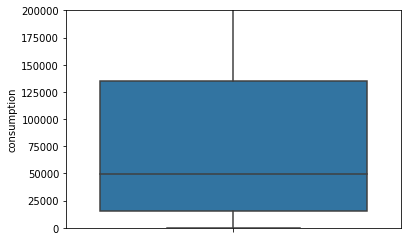

In [18]:
sns.boxplot(y ='consumption',  data=data)
plt.ylim([0,200000])
plt.show()

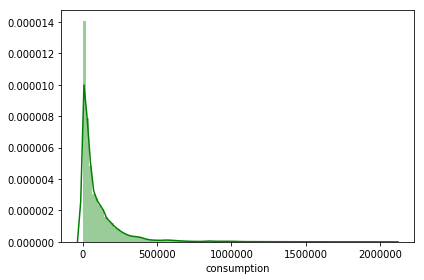

In [19]:
sns.distplot(data.consumption, color="g", bins=100)
plt.tight_layout()

In [20]:
data.consumption.max(), data.consumption.min()

(2085109.4535347074, 0.0)

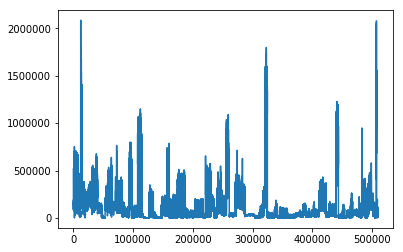

In [21]:
data.consumption.plot()

> Como esta distribuida en el dataset los valores del target

# Exploring Categorical/Ordinal

In [22]:
data.select_dtypes(include=['object', 'bool']).columns

Index(['surface', 'base_temperature', 'monday_is_day_off',
       'tuesday_is_day_off', 'wednesday_is_day_off', 'thursday_is_day_off',
       'friday_is_day_off', 'saturday_is_day_off', 'sunday_is_day_off',
       'timestampIs_month_end', 'timestampIs_month_start',
       'timestampIs_quarter_end', 'timestampIs_quarter_start',
       'timestampIs_year_end', 'timestampIs_year_start'],
      dtype='object')

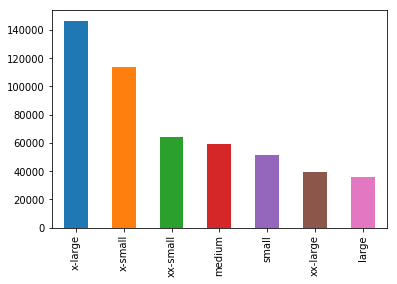

In [23]:
data.surface.value_counts().plot(kind="bar")

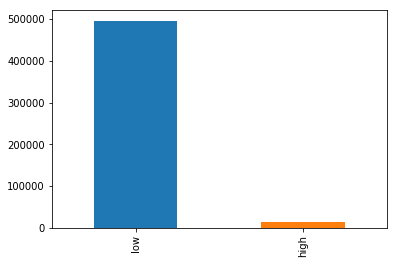

In [24]:
data.base_temperature.value_counts().plot(kind="bar")

## Multiples Variables

In [ ]:
sns.violinplot(y= 'consumption',x ='timestampYear',  data=data, jitter=True)

In [ ]:
sns.swarmplot(x= 'consumption', y= 'surface', data=data)

In [ ]:
pivot_tab = data.pivot_table(index="surface",columns="timestampYear",values="consumption", aggfunc="mean")
sns.heatmap(pivot_tab, annot=False,cmap="hot")

In [ ]:
# data.set_index(['series_id','timestamp'], inplace=True)

In [ ]:
data.head(5)

In [ ]:
data = data.sort_index()

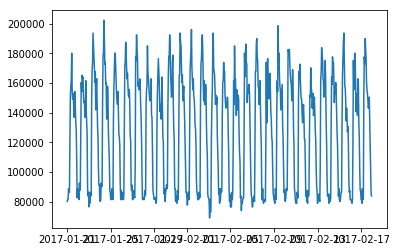

In [54]:
plt.plot(data.loc[(102094),'consumption'])

In [31]:
data["temperature_null"] =  (pd.isnull(data.temperature)).astype(int) 

In [35]:
data.temperature_null.value_counts()

0    280687
1    228689
Name: temperature_null, dtype: int64

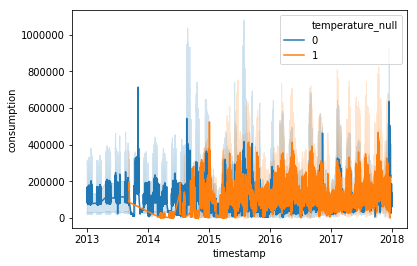

In [36]:
sns.lineplot(x="timestamp", y="consumption",
             hue="temperature_null",
             data=data)

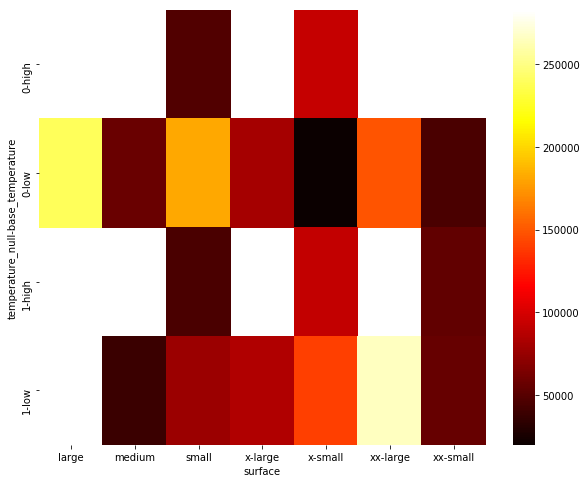

In [43]:
pivot_tnull = data.pivot_table(index=["temperature_null","base_temperature"],columns="surface",values="consumption", aggfunc="mean")
plt.figure(figsize=(10,8))
sns.heatmap(pivot_tnull, annot=False,cmap="hot")

In [44]:
pivot_tnull

surface                                    large        medium          small  \
temperature_null base_temperature                                               
0                high                        NaN           NaN   47941.789388   
                 low               239090.798708  57157.960659  181567.161890   
1                high                        NaN           NaN   45384.981692   
                 low               282848.380112  38258.610800   77245.499002   

surface                                 x-large        x-small       xx-large  \
temperature_null base_temperature                                               
0                high                       NaN   92887.957491            NaN   
                 low               80777.128741   19744.805686  148647.675277   
1                high                       NaN   92363.368800            NaN   
                 low               84939.048649  140655.851867  265916.841045   

surface                                xx-small  
temperature_null base_temperature                
0                high                       NaN  
                 low               44877.895103  
1                high              54095.721751  
                 low               55929.235107

In [ ]:
data.plot(kind="bar",x="temperature_null")